In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pymongo
from pubcrawler.article import Article
from epitator.annodoc import AnnoDoc
from epitator.geoname_annotator import GeonameAnnotator

import pandas as pd
import matplotlib

from reporter import Reporter, MongoQueryReporter

client = pymongo.MongoClient("localhost", 27017)
articles = client.pmc.articles

with open("terms") as f:
    terms = [line.strip() for line in f.readlines()]

## Examine Article Length and GeoName Density

In [10]:
# Alternate subset queries
query = {
    "text_matches": {"$in": terms},
}

query = {
    "article_meta.article_type": "research-article",
}

query = {
    "article_meta.has_body": True
}

query = {
    "article_meta.n_geospans": {"$exists": True}
}

In [3]:
query = {
    "text_matches": {"$in": terms},
    "article_meta.article_type": "research-article",
    "article_meta.has_body": True,
    "article_meta.n_geospans": {"$exists": True}
}
articles.count_documents(query)

2061

In [12]:
cursor = articles.aggregate([
    {"$match": query},
    {"$project": {
        "n_geospans": "$article_meta.n_geospans",
        "length": {"$strLenCP": "$extracted_text"}
    }}
])

In [13]:
cursor_df = pd.DataFrame(cursor)

In [14]:
cursor_df.describe()

,length,n_geospans
count,2061.000000,2061.000000
mean,33491.571082,43.319748
std,16902.014279,77.326713
min,3048.000000,0.000000
25%,24279.000000,14.000000
50%,31158.000000,26.000000
75%,39655.000000,50.000000
max,453774.000000,2448.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13c4bd978>]],
      dtype=object)

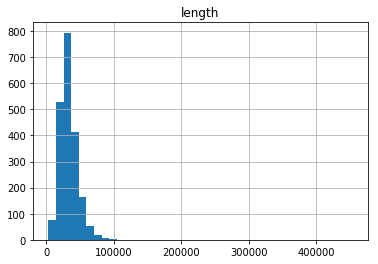

In [20]:
cursor_df.hist(column="length", bins=40)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13c6036d8>]],
      dtype=object)

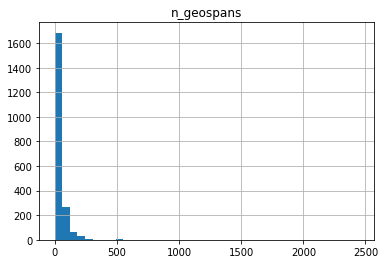

In [21]:
cursor_df.hist(column="n_geospans", bins=40)

In [19]:
cursor_df.n_geospans.quantile(q=0.25)

14.0

In [312]:
cursor_df = pd.DataFrame(geospan_counts)
cursor_df.n_geospans.quantile(q=0.25)

26.0

In [317]:
q25 = geospan_df.n_geospans.quantile(q=0.25)

subset_query = {
    "text_matches": {"$in": terms},
    "article_meta.article_type": "research-article",
    "article_meta.has_body": True,
    "article_meta.n_geospans": {"$gte": q25}
}

In [319]:
articles.count_documents(subset_query)

1558

In [ ]:
pipeline = [
    {"$match": query},
    {""}
]

In [175]:
x = [1, 2, 3, 4, 10, 20, 30]

In [250]:
bisect_right(x, 10)

5

In [249]:
max(bisect_right(x, 10) - 1)

TypeError: 'int' object is not iterable

# Convert dict to mongo query

In [134]:
foo = {
    "dog": "dog",
    "cat": {
        "ear_size": "medium",
        "name": "Harriet",
        "faves": {
            "food": "cat food",
            "musician": "Bob Dylan"
        }
    },
    "rabbit": {
        "ear_size": "big",
        "name": "James",
        "faves": {
            "food": "carrot",
            "musician": "Tori Amos"
        }
    }
}

In [153]:
from collections import MutableMapping

def flatten(d, parent_key='', sep='.'):
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, collections.MutableMapping):
            items.extend(flatten(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

In [154]:
flatten(foo)

{'dog': 'dog',
 'cat.ear_size': 'medium',
 'cat.name': 'Harriet',
 'cat.faves.food': 'cat food',
 'cat.faves.musician': 'Bob Dylan',
 'rabbit.ear_size': 'big',
 'rabbit.name': 'James',
 'rabbit.faves.food': 'carrot',
 'rabbit.faves.musician': 'Tori Amos'}

In [136]:
foo

{'dog': 'dog',
 'cat': {'ear_size': 'medium',
  'name': 'Harriet',
  'faves': {'food': 'cat food', 'musician': 'Bob Dylan'}},
 'rabbit': {'ear_size': 'big',
  'name': 'James',
  'faves': {'food': 'carrot', 'musician': 'Tori Amos'}}}

In [128]:
articles.aggregate

<bound method Collection.aggregate of Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'pmc'), 'articles')>

In [ ]:
query = {
    "text_matches": {
        "$in": terms
    },
    "article_meta": {
        "has_body": True,
        "article_type": "research-article",
        ""
    }
}

In [30]:
query = {
#     "text_matches": {"$in": terms},
    "article_meta": {"$exists": True}
}

In [5]:
query = {
    "text_matches": {"$in": terms},
    "article_meta.n_geospans": {"$exists": False}
}

In [9]:
count = articles.count_documents(query)
count

2182

In [ ]:
query

In [19]:
count

18314

In [35]:
articles.find_one(query).get("article_meta")

{'has_body': True, 'article_type': 'research-article'}

In [7]:
query = {
    "text_matches": {"$in": terms},
    "article_meta.n_geospans": {"$exists": False}
}

In [8]:
articles.count_documents(query)

2182

In [65]:
cursor = articles.find(query)
reporter = MongoQueryReporter(5, articles, query)

In [32]:
for document in cursor:
    article = AnnoDoc(document["extracted_text"]).add_tier(geoname_annotator)
    geospans = article.tiers["geonames"]
    all_geospans = len(geospans)
    n_geospans = sum([1 for span in geospans
                     if span.metadata["geoname"].score > 0.13])
    articles.update_one({"_id": document["_id"]},
                        {"$set": {"article_meta": {
                            "all_geospans": all_geospans,
                            "n_geospans": n_geospans
                        }}})
    reporter.report()

In [ ]:
## Recreating the PubCrawler queue

In [161]:
import multiprocessing as mp

In [162]:
def do_work(queue):
    articles = pymongo.MongoClient("localhost", 27017).pmc.articles
    geoname_annotator = GeonameAnnotator()
    for i in iter(queue.get, "STOP"):
        record = articles.find_one(i)
        article = AnnoDoc(record["extracted_text"]).add_tier(geoname_annotator)
        geospans = article.tiers["geonames"]
        all_geospans = len(geospans)
        n_geospans = sum([1 for span in geospans
                         if span.metadata["geoname"].score > 0.13])
        articles.update_one({"_id": i},
                            {"$set": {"article_meta": {
                                "all_geospans": all_geospans,
                                "n_geospans": n_geospans
                            }}})

In [163]:
def report_work(query):
    reporter = MongoQueryReporter(5, query)
    finished = False
    while finished == False:
        finished = reporter.report()
        time.sleep(5)

In [164]:
num_workers = 2

In [165]:
cursor = articles.find(query, ["_id"])

In [166]:
queue = mp.Queue()
for x in cursor:
    queue.put(x)
for x in range(num_workers):
    queue.put("STOP")

In [168]:
workers = [mp.Process(target=do_work, args=(queue,)) for w in range(num_workers)]

In [169]:
workers += [mp.Process(target=report_work, args=(query,))]

In [170]:
for w in workers:
    w.start()

Process Process-27:
Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-163-6d9e4f851bbe>", line 2, in report_work
    reporter = MongoQueryReporter(5, query)
TypeError: __init__() missing 1 required positional argument: 'query'


{'_id': '6022700', 'xml': '<!DOCTYPE article PUBLIC "-//NLM//DTD JATS (Z39.96) Journal Archiving and Interchange DTD v1.0 20120330//EN" "JATS-archivearticle1.dtd">\n<article xmlns:mml="http://www.w3.org/1998/Math/MathML" xmlns:xlink="http://www.w3.org/1999/xlink" article-type="research-article"><?properties open_access?><front><journal-meta><journal-id journal-id-type="nlm-ta">J Neurodev Disord</journal-id><journal-id journal-id-type="iso-abbrev">J Neurodev Disord</journal-id><journal-title-group><journal-title>Journal of Neurodevelopmental Disorders</journal-title></journal-title-group><issn pub-type="ppub">1866-1947</issn><issn pub-type="epub">1866-1955</issn><publisher><publisher-name>BioMed Central</publisher-name><publisher-loc>London</publisher-loc></publisher></journal-meta><article-meta><article-id pub-id-type="pmid">29950161</article-id><article-id pub-id-type="pmc">6022700</article-id><article-id pub-id-type="publisher-id">9241</article-id><article-id pub-id-type="doi">10.118

In [126]:
for w in workers:
    w.join()

AssertionError: can only join a started process

## Get the tf-idf scores for documents matching a certain term

In [139]:
term = "field area"

In [145]:
all_articles[0]["text_matches"]

['study site']

In [151]:
match_index = []
for i, article in enumerate(all_articles):
    if article.get("text_matches"):
        if term in article.get("text_matches"):
            match_index.append(i)

In [155]:
print(corpus[match_index[0]])




Introduction

A growing body of research on the communicative behaviour of non-human primates has demonstrated that their vocalisations can convey a considerably rich amount of information that is meaningful to receivers (e.g. [1]). For instance, field experiments with various primate species have shown that acoustically distinct alarm calls can inform listeners about specific types of dangers (e.g. [2]–[5]). In some species, there is evidence that signallers produce strings of acoustically variable calls composed in context-specific ways (e.g. [6]–[8]). For example, black-and-white Colobus monkeys (Colobus polykomos, C. guereza) produce two types of vocalisations to predators, which are arranged in event-specific sequences that are seemingly meaningful to others [8].

Food discovery is another event type during which some primates produce highly context-specific vocalisations. Since food is often patchily distributed and seasonally dispersed, food calls can provide listeners with a

In [160]:
i = 593

In [161]:
article_tfidf = tfidf.getrow(i)

In [173]:
dense = article_tfidf.todense()

In [175]:
dense.

array([0.01425685, 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ])

In [157]:
for i in match_index:
    word_indexes = tfidf.getrow(i).todense().A1.argsort()[-10:][::-1]
    article_tfidf = tfidf.getrow(i)
    
    print(word_indexes)
    for i in word_indexes:
        print(word_features[i])

[[0.01425685 0.         0.         ... 0.         0.         0.        ]]
[632189 198563 471176 855415 471461 255138 282795 892066 973154 587331]
kiwi
apple
food
playback
foraging
bonobos
calls
py
sequences
individuals
[[0.        0.0027204 0.        ... 0.        0.        0.       ]]
[ 711305  309924  429585  576144 1020736  694238  444644  995491  734764
  414854]
methanogens
ch4
enceladus
icy
subsurface
mars
europa
solar
moons
earth
[[0.01539038 0.02097378 0.         ... 0.         0.         0.        ]]
[1013019  347431  251864 1030135  739649  350460  399969  739722 1013021
  348150]
stifle
cr
bm
synovial
msc
crp
dogs
mscs
stifles
crcl
[[0.         0.00298952 0.         ... 0.         0.         0.        ]]
[1048546 1016386  888307  886893  879455  745420  255664  449177  594449
  689388]
tert
stromal
pts
pt
promoter
mutation
borderline
expression
intermediate
malignant
[[0. 0. 0. ... 0. 0. 0.]]
[ 748798  323378  462078 1038662  915717  748805 1152022  217778  972059
  972220]


In [43]:
Y = vectorizer2.fit_transform(corpus)

In [45]:
Y.toarray()

array([[0.00484436, 0.0078168 , 0.00484436, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00906395, 0.        ,
        0.00906395],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.01458545,
        0.        ],
       [0.        , 0.01433153, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [48]:
vectorizer2.get_feature_names()

['0001',
 '001',
 '003',
 '004',
 '01',
 '04',
 '040',
 '041',
 '043',
 '05',
 '051',
 '057',
 '060',
 '073',
 '076',
 '08',
 '080',
 '094',
 '10',
 '100',
 '1000',
 '101112',
 '1083',
 '11',
 '1187',
 '12',
 '121',
 '124',
 '13',
 '1360',
 '137',
 '14',
 '144',
 '1472',
 '15',
 '16',
 '163',
 '17',
 '177',
 '178',
 '18',
 '1827',
 '18f',
 '19',
 '190',
 '1905',
 '195',
 '1964',
 '1970',
 '1980',
 '1991',
 '1997',
 '1999',
 '20',
 '2000',
 '2001',
 '2002',
 '2003',
 '2004',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2013',
 '21',
 '211',
 '214',
 '22',
 '2235',
 '23',
 '24',
 '243',
 '25',
 '2500',
 '26',
 '27',
 '2732',
 '2766',
 '277',
 '28',
 '29',
 '30',
 '303',
 '304',
 '31',
 '314',
 '32',
 '33',
 '34',
 '342',
 '349',
 '35',
 '352',
 '358',
 '36',
 '37',
 '374',
 '3742',
 '38',
 '3844',
 '385',
 '39',
 '392',
 '40',
 '4000',
 '41',
 '42',
 '43',
 '431',
 '435',
 '44',
 '448',
 '454',
 '46',
 '460',
 '46073',
 '47',
 '471',
 '48',
 '4806',
 '484',
 '49',
 '50',
 '507

In [50]:
vectorizer2.vocabulary_

{'background': 418,
 'many': 1611,
 'countries': 752,
 'in': 1366,
 'the': 2526,
 'global': 1210,
 'south': 2386,
 'are': 349,
 'hard': 1250,
 'pressed': 1984,
 'to': 2558,
 'identify': 1330,
 'country': 753,
 'personnel': 1901,
 'with': 2742,
 'adequate': 259,
 'training': 2579,
 'human': 1312,
 'subjects': 2452,
 'research': 2176,
 'ethics': 996,
 'participate': 1863,
 'as': 361,
 'investigators': 1469,
 'staff': 2408,
 'or': 1816,
 'members': 1649,
 'of': 1783,
 'review': 2206,
 'bodies': 477,
 'international': 1452,
 'partners': 1870,
 'have': 1255,
 'attempted': 391,
 'address': 257,
 'this': 2543,
 'need': 1731,
 'by': 495,
 'incorporating': 1380,
 'short': 2324,
 'courses': 755,
 'and': 323,
 'workshops': 2755,
 'into': 1460,
 'their': 2527,
 'capacity': 510,
 'building': 491,
 'programs': 2018,
 'supporting': 2479,
 'host': 1300,
 'initiatives': 1416,
 'implement': 1351,
 'efforts': 932,
 'own': 1844,
 'while': 2729,
 'such': 2459,
 'generally': 1191,
 'share': 2316,
 'common':

In [52]:
vectorizer2.vocabulary_.get("background")

418

In [54]:
vectorizer2.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': None,
 'min_df': 1,
 'ngram_range': (1, 1),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [56]:
X = vectorizer2.inverse_transform(Y)

In [61]:
x = X[0]

In [62]:
y = Y[0]

In [67]:
pd.DataFrame(zip(x, y))

,0,1
0,background,"(0, 418)\t0.006488649324705781\n (0, 1611)\..."


## Code for viewing documents

In [17]:
terms

['field work',
 'fieldwork',
 'field study',
 'field site',
 'field area',
 'study site',
 'study location',
 'study area',
 'research site',
 'research location',
 'sampling site',
 'sampling location',
 'sampling area']

In [25]:
def print_article(article):
    print("""
PMC ID

{}


TITLE

{}


METADATA

{}


TEXT MATCHES

{}


EXTRACTED TEXT

{}""".format(article.get("_id"),
             article.get("article_title"),
             article.get("article_meta"),
             article.get("text_matches"),
             article.get("extracted_text").strip()))

In [18]:
def view_one_article(query={ "$match": { "text_matches": { "$in": terms } } }):
    query = [
        query,
        { "$sample": { "size": 1 } }
    ]
    article = articles.aggregate(query).next()
    print("""
PMC ID

{}


TITLE

{}


METADATA

{}


TEXT MATCHES

{}


EXTRACTED TEXT

{}""".format(article.get("_id"),
             article.get("article_title"),
             article.get("article_meta"),
             article.get("text_matches"),
             article.get("extracted_text").strip()))

In [31]:
terms

['field work',
 'fieldwork',
 'field study',
 'field site',
 'field area',
 'study site',
 'study location',
 'study area',
 'research site',
 'research location',
 'sampling site',
 'sampling location',
 'sampling area']

In [46]:
view_one_article()


PMC ID

6210248


TITLE

The Effect of Different Habitat Types and Ontogenetic Stages on the Diet Shift of a Critically Endangered Fish Species, Coreius guichenoti (Sauvage and Dabry de Thiersant, 1874)


METADATA

{'has_body': True, 'article_type': 'research-article'}


TEXT MATCHES

['study area', 'sampling site']


EXTRACTED TEXT

1. Introduction

The identification and protection of fish critical habitats are central to the active management of species at risk [1,2]. Generally, the spawning grounds and nursery, migration, and rearing areas on which fish species depend directly to complete their life history cycles, are identified as the critical habitats for fish species [1]. However, many fish species use different critical habitats within different life history stages [3,4]. The distance between critical habitats may extend to several hundred or thousands of kilometers. Due to environmental heterogeneity in different habitats, the fish species may exhibit plastic dietary pattern

In [66]:
problematic_terms = terms[-3:]

In [76]:
view_one_article({ "$match": { "text_matches": { "$in": problematic_terms } } })


PMC ID

6002991


TITLE

Decadal stability in genetic variation and structure in the intertidal seaweed Fucus serratus (Heterokontophyta: Fucaceae)


METADATA

{'has_body': True, 'article_type': 'research-article'}


TEXT MATCHES

['sampling site', 'sampling location']


EXTRACTED TEXT

Background

Understanding temporal stability of genetic structure and diversity is crucial for the utility of temporal snapshots in conservation management and to infer how climate-induced range shifts might affect the future distribution and adaptive potential of species. In trailing edge populations, effective population size and genetic diversity are considered major keys to adaptive potential and subsequent persistence under climate change [1, 2]. In contrast, the evolutionary potential and survival of low-diversity leading edge populations [3] may be either enhanced or impaired by the ‘surfing’ of new mutations that can rapidly increase in frequency over iterated founder events, depending on wheth

In [53]:
phrase = """
"Following optic nerve injury, few axons grow beyond the lesion, but we find these axons branch and form loops proximal to the lesion"
"""

In [54]:
cursor = articles.find({'$text': {'$search': phrase}})

In [55]:
print_article(cursor.next())


PMC ID

5575138


TITLE

3D Visualization of Individual Regenerating Retinal Ganglion Cell Axons Reveals Surprisingly Complex Growth Paths


METADATA

{'has_body': True, 'article_type': 'research-article'}


TEXT MATCHES

['field area']


EXTRACTED TEXT

Significance Statement

Retinal ganglion cells (RGCs) are viewed as being incapable of mounting lengthy axon regeneration. Using whole tissue immunolabeling, we establish a technique to visualize and trace the entire paths of small populations of genetically labeled RGC axons as they regenerate. Following optic nerve injury, few axons grow beyond the lesion, but we find these axons branch and form loops proximal to the lesion. A regeneration inducing treatment further exacerbates branching and tortuous growth, while only modestly increasing the number of RGC axons that successfully grow beyond the lesion. Our study demonstrates extensive and circuitous RGC axon elongation both in pre- and post-lesion regions, highlighting the need to 

In [24]:
view_one_article({ "$match": {'$text': {'$search': phrase}}})


PMC ID

5063180


TITLE

Linking quality of care and training costs: cost‐effectiveness in health professions education


METADATA

{'has_body': True, 'article_type': 'research-article'}


TEXT MATCHES

None


EXTRACTED TEXT

Introduction

Health professions education involves training and certifying care‐provider groups in specific procedures. However, there are considerable associated costs that have been estimated globally to amount to more than 80 billion Euros per year.1 Because some training is usually more effective than no training2 but often associated with considerable monetary and time costs, identifying the most cost‐effective strategy can be challenging.3 Nonetheless, many institutions have to balance the need for training new health care providers in performing certain types of procedures against the costs associated with training.4 Cost‐effectiveness analyses are suitable for these types of decisions; however, only a few studies have attempted to link training costs to 

In [31]:
# To sample an article with text matches from our terms:
art = articles.aggregate([
    { "$match": { "text_matches": { "$in": terms } } },
    { "$sample": { "size": 1 } }
]).next()

# Print the ID, metadata, matches, and extracted text of your article
print("""
PMC ID

{}


TITLE

{}


METADATA

{}


TEXT MATCHES

{}


EXTRACTED TEXT

{}""".format(art.get("_id"),
             art.get("article_title"),
             art.get("article_meta"),
             art.get("text_matches"),
             art.get("extracted_text").strip()))


PMC ID

3543354


TITLE

None


METADATA

None


TEXT MATCHES

['study area']


EXTRACTED TEXT

Introduction

The transfer of energy and recycling of nutrients via the decomposition of organic matter is a central unifying process that links all organisms to the functioning of ecosystems [1]. However, dead organic matter varies enormously in its spatial and temporal distribution [2], and this determines the magnitude of its contribution to nutrient cycling [3] and the diversity and dynamics of its consumers [4]. Animal carrion is the most nutrient-rich form of dead organic matter [5], and recent reviews have highlighted the overlooked role of carrion in food webs [6], [7], [8], and driving variation in biodiversity and ecological processes in landscapes [5], [9]. Widespread changes to the population dynamics of large vertebrates, through loss of top predators [10] or hunting and harvesting of wild herbivores [11], are affecting the distribution and input of carrion resources in some te

In [24]:
soup = BeautifulSoup(art["xml"])

In [33]:
soup.front.find("article-id", attrs={"pub-id-type": "pmc"}).get_text()

'3573865'

In [136]:
article.article_type()

'research-article'

In [175]:
article.soup.find("front").find("journal-meta").find("journal-title").get_text()

'PLoS ONE'

In [14]:
article.journal_title()

'Methods in Ecology and Evolution'

In [16]:
article.article_title()

'Advances in multiplex PCR: balancing primer efficiencies and improving detection success'

## DataFrame scratch

In [107]:
foo = pd.DataFrame()

In [117]:
pd.DataFrame({"one": [10], "two": ["dog"]})

,one,two
0,10,dog


In [119]:
pd.DataFrame.from_records([{"one": 10, "two": "dog"}])

,one,two
0,10,dog


In [112]:
pd.concat([pd.DataFrame([i], columns=['A']) for i in range(5)],ignore_index=True)

,A
0,0
1,1
2,2
3,3
4,4


In [ ]:
pd.concat([foo])

## Count article types and other metadata

TODO: Check if an article's `_id` is in `result_set` and add those to a different default_dict

In [25]:
articles.count_documents({})

211

In [15]:
cursor = articles.aggregate([{ "$sample": { "size": articles.count_documents({}) } }])

KeyboardInterrupt: 

In [ ]:
count = articles.count_documents({})
cursor = articles.find({})

In [46]:
reporter = Reporter(25, len(matches))

rows = []

for idx, record in enumerate(matches):
    reporter.report(idx)

    row = {}
    article = Article(record["xml"])

    row["id"] = record["_id"]
    row["keywords"] = article.keywords()
    row["id_types"] = list(article.pub_ids().keys())
    row["article_type"] = article.article_type()
    row["has_body"] = True if article.soup.body else False
    row["text_matches"] = record.get("text_matches")
    row["article_title"] = article.article_title()
    row["journal_title"] = article.journal_title()
    row["text_length"] = len(record["extracted_text"])

    rows.append(row)

Processed 175 articles (82.9%) in 0m8s; about 0m2s left.


KeyboardInterrupt: 

In [47]:
article_df = pd.DataFrame.from_records(rows)

In [282]:
article_df["any_matches"] = [False if row is None else True for row in article_df["text_matches"]]
article_df.groupby(["any_matches"]).size()

any_matches
False    19519
True       481
dtype: int64

In [356]:
article_df.to_csv("article_sample.csv")

In [285]:
article_df.groupby(["any_matches", "article_type"]).size()
art_types = article_df.groupby(["any_matches", "article_type"]).size().reset_index()
art_types.columns = ["any_matches", "article_type", "count"]
art_types.sort_values(by = ["any_matches", "count"], ascending=False)

,any_matches,article_type,count
39,True,research-article,446
40,True,review-article,15
32,True,brief-report,7
38,True,protocol,4
33,True,case-report,3
37,True,other,3
34,True,data-paper,1
35,True,editorial,1
36,True,letter,1
28,False,research-article,14138


In [364]:
keep_vars = ["id", "any_matches"]
unnest_var = "keywords"

def unnest(data, unnest_var, keep_vars):
    all_vars = keep_vars + [unnest_var]
    nested = article_df.loc[:, keep_vars + [unnest_var]]
    lens = [len(item) if item is not None else 1 for item in nested[unnest_var]]
    unnested_dict = {var: np.repeat([nested[var].values], lens) for var in keep_vars}
    unnested_dict[unnest_var] = np.hstack(nested[unnest_var])
    unnested = pd.DataFrame(unnested_dict)
    return(unnested)

In [369]:
keywords = unnest(article_df, "keywords", ["id", "any_matches"])

keywords.to_csv("keywords.csv")

id_types = unnest(article_df, "id_types", ["id", "any_matches"])

id_types.to_csv("id_types.csv")

text_matches = unnest(article_df, "text_matches", ["id"])

text_matches.to_csv("text_matches.csv")

### Old version

In [131]:
id_types = defaultdict(int)
article_types = defaultdict(int)
keywords = defaultdict(int)

reporter = Reporter(10, len(matches))

for idx, doc in enumerate(matches):
    if idx is not 0 and idx % reporter.interval is 0:
        reporter.report(idx)
    article = Article(doc["xml"])
    
    kwds = article.keywords()
    if kwds:
        for kwd in kwds:
            keywords[kwd] += 1
    
    ids = article.pub_ids().keys()
    if len(ids) is 0:
        id_types["none"] += 1
    else:
        for item in ids:
            id_types[item] += 1
    
    article_type = article.article_type()
    if article_type:
        article_types[article_type] += 1



Processed 240 articles (96.0%) in 0m12s; about 0m1s left.


In [105]:
keywords = pd.DataFrame(list(keywords.items()), columns=["keyword", "count"])

In [106]:
keywords.sort_values("count", ascending=False)

,keyword,count
43,inflammation,6
587,oxidative stress,5
159,epidemiology,5
183,Obesity,4
279,Prostate cancer,4
1220,breast cancer,4
647,SNP,4
1833,cytotoxicity,4
45,mitochondria,4
294,depression,4


In [97]:
id_types

defaultdict(int,
            {'pmid': 18771,
             'pmc': 20000,
             'publisher-id': 13829,
             'doi': 17408,
             'pii': 1117,
             'pmc-scan': 1198,
             'manuscript': 206,
             'coden': 219,
             'art-access-id': 208,
             'other': 134,
             'publisher-manuscript': 22,
             'sici': 27,
             'medline': 4})

In [98]:
article_types

defaultdict(int,
            {'research-article': 14584,
             'abstract': 507,
             'brief-report': 318,
             'retraction': 12,
             'other': 748,
             'review-article': 1294,
             'editorial': 315,
             'case-report': 899,
             'correction': 245,
             'news': 82,
             'discussion': 42,
             'letter': 302,
             'meeting-report': 67,
             'product-review': 31,
             'reply': 9,
             'article-commentary': 92,
             'addendum': 3,
             'book-review': 306,
             'protocol': 31,
             'obituary': 29,
             'rapid-communication': 15,
             'methods-article': 13,
             'in-brief': 17,
             'systematic-review': 11,
             'introduction': 9,
             'oration': 2,
             'books-received': 3,
             ' case-report': 1,
             'data-paper': 8,
             'report': 2,
             'announcement'

## Look at the text of a single document matching a search result

In [23]:
articles.update_many(
    filter={},
    update={ "$unset": { "text_matches": "" } }
)